In [1]:
import json
import random
import os

from itertools import product
from tqdm import tqdm
import math
from functools import lru_cache

from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_context("notebook", font_scale=1.2)
sns.color_palette('colorblind')
figsize = (20, 5)

import numpy as np
from collections import Counter, OrderedDict
from domain import *
from helper import *

splits = ['train', 'test']
evaluation = ['I', 'SS', 'LS', 'SL', 'LL']
max_op = 20
max_op_train = 10
max_value_train = 100
max_value_test = 10000


In [2]:
split2dataset = {}
for split in splits:
    split2dataset[split] = json.load(open('expr_%s.json'%split))
    
split2symset = {}
for split in splits:
    split2symset[split] = json.load(open('sym_%s.json'%split))

# Dataset size

In [3]:
for split in splits:
    dataset = split2dataset[split]
    print(f'{split}: {len(dataset)}', end=' ')
    if split != 'train':
        counts = Counter([x['eval'] for x in split2dataset[split]])
        total_count = sum(counts.values())
        for e in evaluation:
            c = counts[e]
            p = round(c/total_count*100, 2)
            print(f'{e}: {c} ({p}%)', end=' ')
    print()

train: 998000 
test: 46620 I: 9980 (21.41%) SS: 8000 (17.16%) LS: 10000 (21.45%) SL: 8640 (18.53%) LL: 10000 (21.45%) 


In [4]:
print(dataset[0])

{'id': 'test_00000000', 'img_paths': ['7/exp60078.jpg'], 'expr': '7', 'head': [-1], 'res': 7, 'res_all': [7], 'eval': 'I', 'expr_image': 'test_00000000.jpg'}


# Symbol Distribution

Observations:
The test split SL has a much higher ratio of * than others

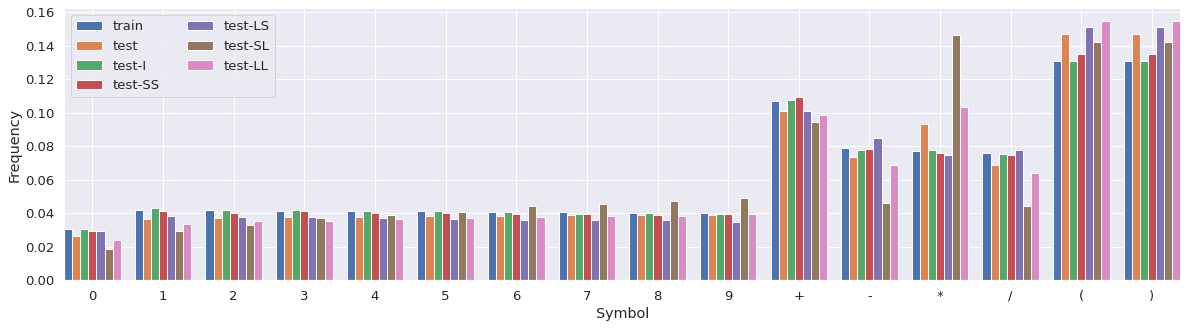

In [5]:
show_subsplit = True
bar_keys = SYMBOLS

def sample2bar_key(sample):
    r = sample['expr']
    return r

# Set general font size
fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    all_points = [y for x in all_points for y in x]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            all_points = [y for x in all_points for y in x]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Symbol')
plt.ylabel('Frequency')

# ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.legend(ncol=2)

split1 = 'train'
dist1 = data_bars[split1]
split2 = 'test'
dist2 = data_bars[split2]
kld = np.sum(np.array(dist1) * (np.log(dist1) - np.log(dist2)))
# plt.title(f'KLD({split1}, {split2})={kld:.4f}')
plt.margins(x=0)
plt.savefig('figures/symbol_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Number of operators distribution

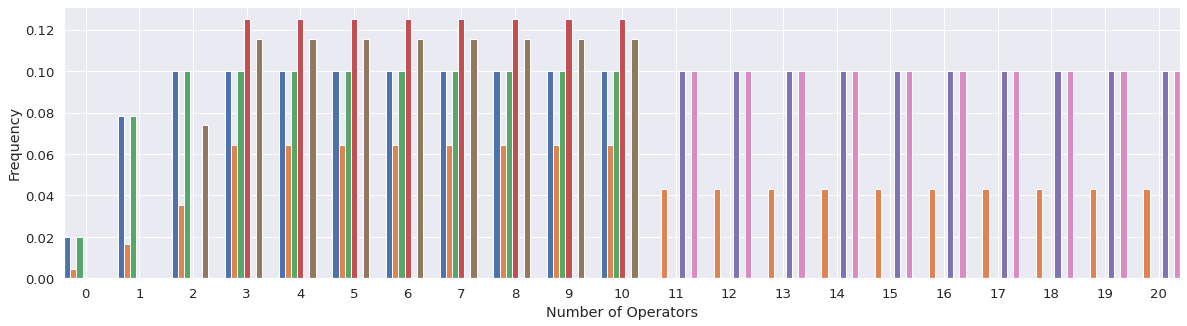

In [6]:
show_subsplit = True

bar_keys = list(range(21))

@lru_cache
def compute_n_op(expr):
    return len([1 for x in expr if x in OPERATORS])

def sample2bar_key(sample):
    r = compute_n_op(sample['expr'])
    return r

fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        

# data_bars = {k:v for k, v in data_bars.items() if k in ['train','test-LS']}
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Number of Operators')
plt.ylabel('Frequency')
plt.margins(x=0)
# plt.legend(ncol=2)
plt.savefig('figures/operators_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Expression Length distribution

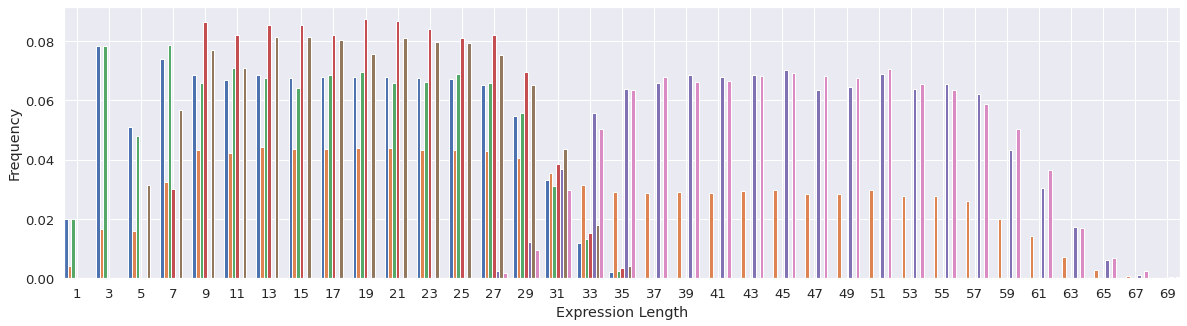

In [7]:
show_subsplit = True

max_len = max(len(x['expr']) for x in split2dataset['test'])
bar_keys = list(range(1, max_len+1, 2))

def sample2bar_key(sample):
    r = len(sample['expr'])
#     r = (r // 4) * 4 + 1
    return r

fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        

# data_bars = {k:v for k, v in data_bars.items() if k in ['train','test-LS']}
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Expression Length')
plt.ylabel('Frequency')
plt.margins(x=0)
# plt.legend(ncol=2)
plt.savefig('figures/expr_length_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Result distribution

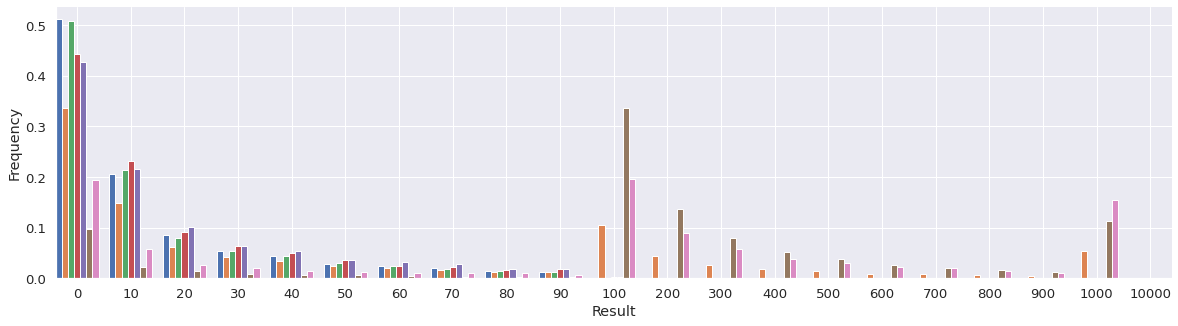

In [8]:
# show_subsplit = True
# bar_keys = list(range(10)) + list(np.arange(1, 11)*10)
bar_keys = list(np.arange(0, 10)*10) + list(np.arange(1, 11)*100) + [10000]

def sample2bar_key(sample):
    r = sample['res']
    for i, bar in enumerate(bar_keys):
        if r < bar:
            return bar_keys[i-1]
    return bar_keys[-1]


fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Result')
plt.ylabel('Frequency')

split1 = 'train'
split2 = 'test'
median1 = int(np.median([x['res'] for x in split2dataset[split1]]))
median2 = int(np.median([x['res'] for x in split2dataset[split2]]))
# plt.title(f'Median({split1})={median1}, Median({split2})={median2}')
plt.margins(x=0)
# plt.legend(ncol=2)
plt.savefig('figures/result_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
dataset = split2dataset['test']
print(len([1 for x in dataset if x['res'] > 100]) / len(dataset))

print(sum([v for k, v in zip(bar_keys, data_bars['test-LL']) if k < 100]))

0.28972543972543974
0.3644


In [10]:
dataset = split2dataset['train']
dataset = [x for x in dataset if x['res'] == 100]
print(len(dataset))
print(dataset[:3])

1063
[{'id': 'train_00100950', 'img_paths': ['4/exp75822.jpg', 'times/exp53375.jpg', '5/exp106547.jpg', 'times/exp62375.jpg', '5/exp84534.jpg'], 'expr': '4*5*5', 'head': [1, 3, 1, -1, 3], 'res': 100, 'res_all': [4, 20, 5, 100, 5], 'expr_image': 'train_00100950.jpg'}, {'id': 'train_00103988', 'img_paths': ['5/exp53926.jpg', 'times/times_76031.jpg', '5/exp90813.jpg', 'times/exp6032.jpg', '4/exp51812.jpg'], 'expr': '5*5*4', 'head': [1, 3, 1, -1, 3], 'res': 100, 'res_all': [5, 25, 5, 100, 4], 'expr_image': 'train_00103988.jpg'}, {'id': 'train_00111752', 'img_paths': ['5/exp53783.jpg', 'times/times_55162.jpg', '(/exp41940.jpg', '5/exp74272.jpg', 'times/exp56542.jpg', '4/exp92097.jpg', ')/exp37140.jpg'], 'expr': '5*(5*4)', 'head': [1, -1, 4, 4, 1, 4, 4], 'res': 100, 'res_all': [5, 100, -1, 5, 20, 4, -1], 'expr_image': 'train_00111752.jpg'}]


# Tree depth

In [11]:
@lru_cache
def compute_tree_depth(head):
    @lru_cache
    def depth(i):
        """The depth of node i."""
        if head[i] == -1:
            return 1
        return depth(head[i]) + 1
    
    return max(depth(i) for i in range(len(head)))

sample = split2dataset['test'][5000]
print(sample['expr'], sample['head'], compute_tree_depth(tuple(sample['head'])))

7/2*(9*5) [1, 3, 1, -1, 6, 6, 3, 6, 6] 3


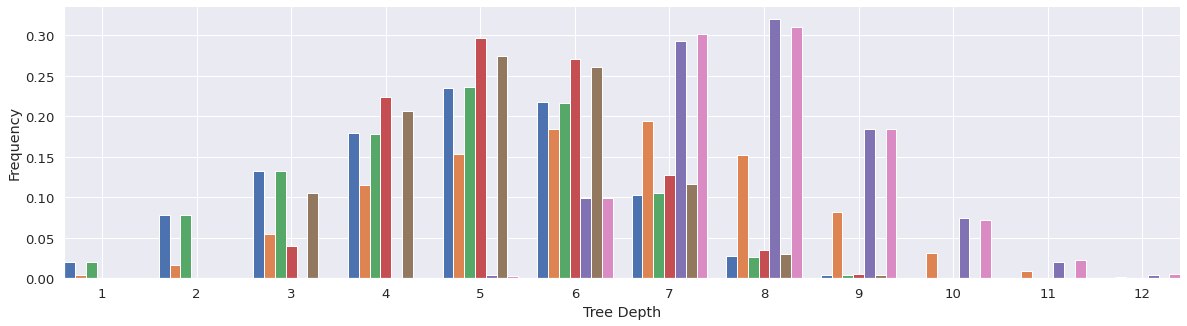

In [12]:
show_subsplit = True
bar_keys = list(range(1, 13))

def sample2bar_key(sample):
    r = compute_tree_depth(tuple(sample['head']))
    return r

fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Tree Depth')
plt.ylabel('Frequency')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

split1 = 'train'
split2 = 'test'
median1 = int(np.median([sample2bar_key(x) for x in split2dataset[split1]]))
median2 = int(np.median([sample2bar_key(x) for x in split2dataset[split2]]))
# plt.title(f'Median({split1})={median1}, Median({split2})={median2}')
plt.margins(x=0)
# plt.legend(ncol=2)
plt.savefig('figures/tree_depth_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Max dependency

In [13]:
@lru_cache
def compute_max_dep(heads):
    return max([0] + [abs(i-h) for i, h in enumerate(heads) if h != -1])

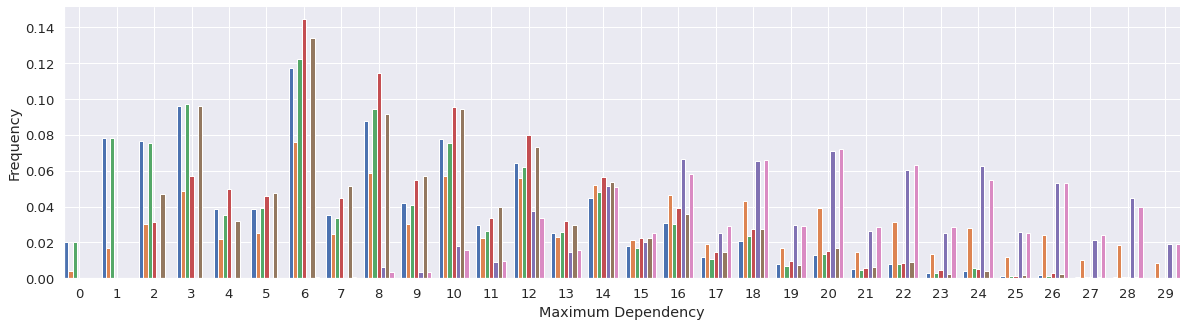

In [14]:
show_subsplit = True
bar_keys = list(range(0, 30))

def sample2bar_key(sample):
    r = compute_max_dep(tuple(sample['head']))
    return r

fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Maximum Dependency')
plt.ylabel('Frequency')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

split1 = 'train'
split2 = 'test'
median1 = int(np.median([sample2bar_key(x) for x in split2dataset[split1]]))
median2 = int(np.median([sample2bar_key(x) for x in split2dataset[split2]]))
# plt.title(f'Median({split1})={median1}, Median({split2})={median2}')
plt.margins(x=0)
# plt.legend(ncol=2)
plt.savefig('figures/dependency_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Parenthesis depth

In [15]:
lps = '('
rps = ')'

def compute_ps_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

print(compute_ps_depth('1*2*(1+2*((3+4)+(3-1))'))

3


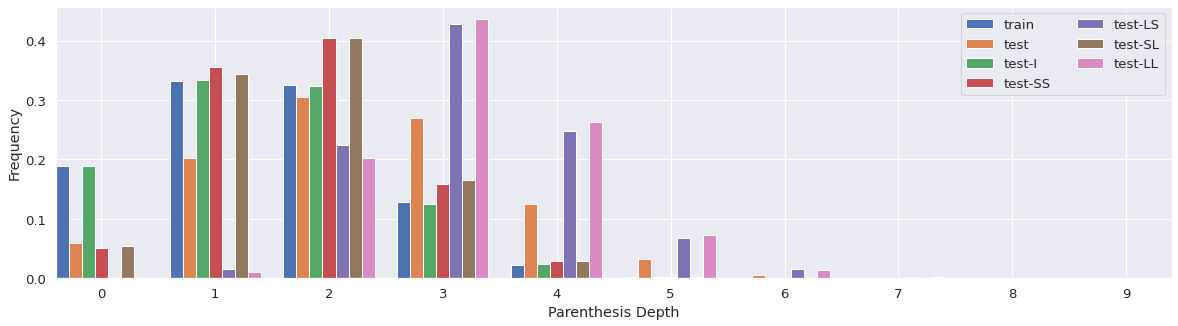

In [16]:
show_subsplit = True
bar_keys = list(range(10))

def sample2bar_key(sample):
    r = compute_ps_depth(sample['expr'])
    return r

fig, ax = plt.subplots(figsize=figsize)

# Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(16)

data_bars = OrderedDict()
for split in splits:
    dataset = split2dataset[split]
    all_points = [sample2bar_key(x) for x in dataset]
    counts = Counter(all_points)
    total = len(all_points)
    freqs = [counts[x]/total for x in bar_keys]
    data_bars[split] = freqs
    if split != 'train' and show_subsplit:
        for e in evaluation:
            all_points = [sample2bar_key(x) for x in dataset if x['eval'] == e]
            counts = Counter(all_points)
            total = len(all_points)
            freqs = [counts[x]/total for x in bar_keys]
            data_bars[split + '-' + e] = freqs
        
    
bar_plot(ax, data_bars)
pos = np.arange(len(freqs))
plt.xticks(pos, bar_keys)
plt.xlabel('Parenthesis Depth')
plt.ylabel('Frequency')
plt.legend(ncol=2)
plt.margins(x=0)
plt.show()

# Visualize rendered images

train ============================================================
unique images for each symbol:
[('(', 2989), (')', 2983), ('*', 450), ('+', 4082), ('-', 4516), ('/', 117), ('0', 1357), ('1', 4745), ('2', 4657), ('3', 1851), ('4', 1230), ('5', 756), ('6', 609), ('7', 564), ('8', 548), ('9', 556)]
0*0+(6+4+7) = 17


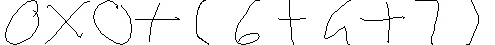

4+2/9+0*8 = 5


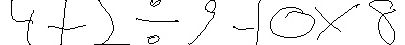

9*((8-(8-5/8))*(2/(5+4)))-2 = 7


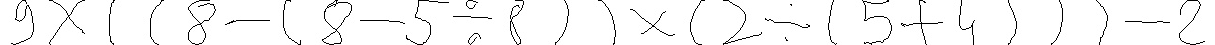

test ============================================================
unique images for each symbol:
[('(', 798), (')', 797), ('*', 120), ('+', 1089), ('-', 1205), ('/', 33), ('0', 363), ('1', 1266), ('2', 1243), ('3', 495), ('4', 329), ('5', 202), ('6', 163), ('7', 152), ('8', 147), ('9', 149)]
6*9/3+((7-(3+3))*(1-3*(3+9))-7)-3 = 15


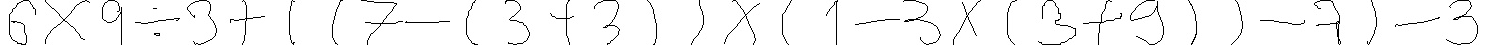

(6/3+7*1+4/(2+2)+(4+7)-(2+1/5))/(4-(6/7-5*(8*(6+7)))) = 5


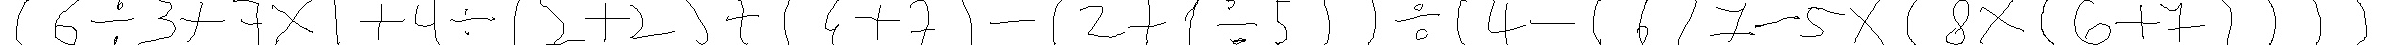

(5+9*7)*6 = 408


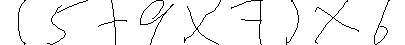

test-I============================================================
4/((5-3*2*9+5)/((2+6+0)*3)) = 4


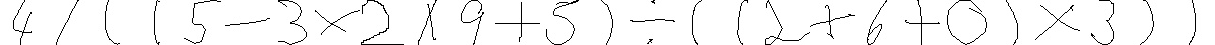

(2+(8+8))*5 = 90


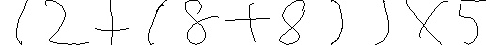

(1-0)/(6*(1*7)/2/(5+4))+2 = 3


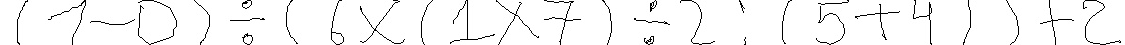

test-SS============================================================
6*7+8+(3-1)*(8-1) = 64


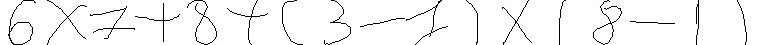

((5-3)/1+6)/(2/(4-(1-8)))*(3-3)+9 = 9


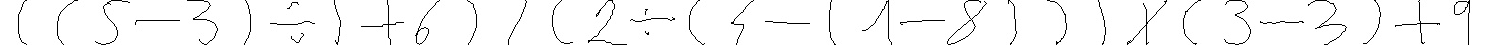

7*(9*0+2)-(0-0)*3+(3+6)/4 = 17


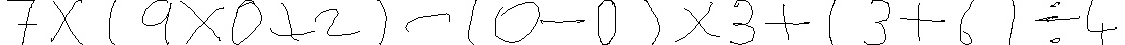

test-LS============================================================
((4-4/9)/(1+7*6)+6)/((3+0-8/6/9)/9+(1-0)) = 4


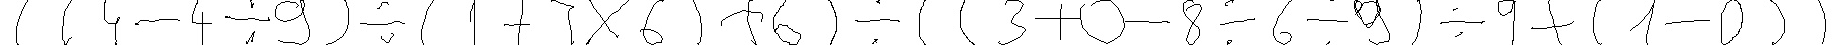

(7-(1-4+(6-5)))/(1/(9/4))-(4-6)/(1/9)*((8+(4+3))*(6/(9-0)))*1 = 6


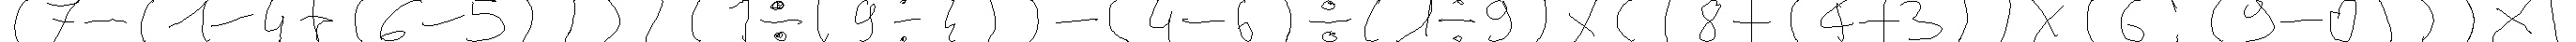

6-3+(0+(6-2))*(6-5+(8-0))+0+(0-0/7)*7/(8+4-(5-5))*(0+7/1) = 39


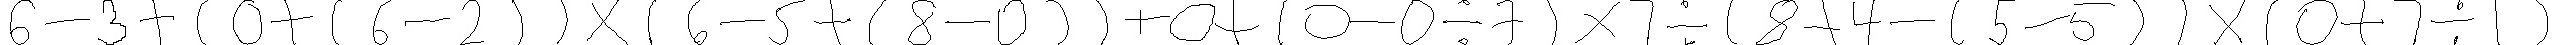

test-SL============================================================
0+8+(6+6-0+7*9*5) = 335


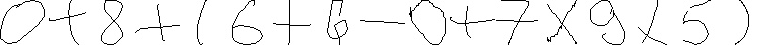

6*(3*(8-0))-2/1*7 = 130


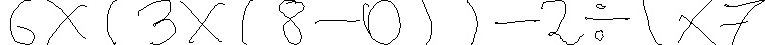

6*(9/2)*(6/(6+(5*(7*4)-6))) = 30


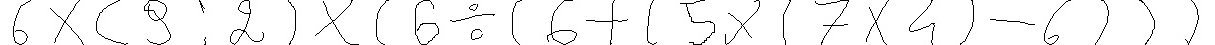

test-LL============================================================
(8-(6+3-(1+2*8)*8)/3*4)*((6/7+5)*5*(1*4)+7) = 1016


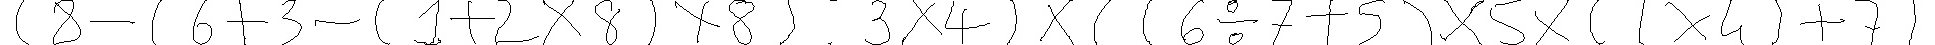

8+(2/(9/1)-(3+2+3*7)*7-(3-8))-(0-8) = 8


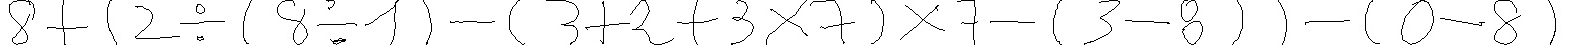

8*6/8+7*(9-2)/(9*5*6/(7*8/(4+(2/7-5)))-4/8/8) = 9


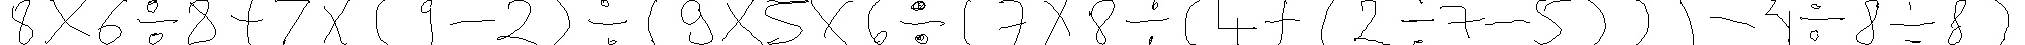

In [17]:
for split in splits:
    dataset = split2dataset[split]
    print(split, '='*60)
    print('unique images for each symbol:')
    all_images = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in set(all_images)]).items()))
    for _ in range(3):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']) + ' = ' + str(sample['res']))
        display(img)

for e in evaluation:
    print('test-' + e + '='*60)
    dataset = [x for x in split2dataset['test'] if x['eval'] == e]
    for _ in range(3):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']) + ' = ' + str(sample['res']))
        display(img)